In [3]:
import os
import numpy as np
import pandas as pd
import pickle
from scipy.stats import ttest_ind
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from urllib.parse import unquote, quote, urlparse, urlunparse
import lxml
from pathlib import Path
import seaborn as sns

from selenium import webdriver

In [98]:
directory = r'data/wikispeedia_articles_html/wpcd/wp/'

df_test =pd.DataFrame(columns=['X', 'Y', 'link', 'page', 'distance'])
driver = webdriver.Firefox()
j = 0

for filename in os.listdir(directory):
  f = os.path.join(directory, filename)
  for file in os.listdir(f):

    page = 'file://'+os.getcwd()+'/' + os.path.join(f,quote(file))

    path = Path(page)
    if path.suffix != '.htm':
      continue
    driver.get(page)

    js = '''function getCoords(elem) {let box = elem.getBoundingClientRect();return {X : box.left + window.pageXOffset, Y : box.top + window.pageYOffset, Link : elem.getAttribute('title')};}
    const allElements = document.getElementsByTagName('a');
    coords = [document.title]
    for (const element of allElements) {
      if (element.classList != 'image' && element.classList != 'internal' && element.title.length > 0){
        coords.push(getCoords(element))
    }
    }
    return coords
    '''
    test = driver.execute_script(js)
    
    for i in range(1, len(test)):
      df_test.loc[j] = [test[i]['X'], test[i]['Y'], test[i]['Link'], test[0], np.sqrt(test[i]['X']**2 + test[i]['Y']**2)] 
      j += 1
    j +=1
driver.quit()


In [44]:
df_test = pd.read_pickle('data/links_in_pages_DF.pkl')
pd.options.display.max_rows = 3000

,X,Y,link,page,distance
0,211.649994,74.949997,Dál Riata,Áedán mac Gabráin,224.528889
1,281.850006,74.949997,Kingdom,Áedán mac Gabráin,291.645209
2,432.149994,74.949997,Scotland,Áedán mac Gabráin,438.601322
3,597.750000,74.949997,Ireland,Áedán mac Gabráin,602.430547
4,939.750000,74.949997,Columba,Áedán mac Gabráin,942.734090
...,...,...,...,...,...
185487,314.250000,2789.466553,Romania,ZX Spectrum,2807.111810
185488,383.549988,2789.466553,Brazil,ZX Spectrum,2815.712031
185489,414.149994,3126.899902,Nintendo,ZX Spectrum,3154.207225
185490,984.750000,3126.899902,Jet Set Willy,ZX Spectrum,3278.297662


In [34]:
#functions
'''
def verify(element):
    if element is None:
        return True
    if element.get('href') is None:
        return True
    if element.get('href')[-7:-4] == 'jpg' or element.get('href')[-7:-4] == 'png':
        return True
    return False

def links_name(link):
    link_name = ''
    if link.text != '':
        if link.get('title') != None:
            link_name = link.get('title')
        else: 
            link_name = link.text
    return link_name

def link_par_position(page, link):
    par_occurences = np.array(0)
    for i in range(globals()['count_%s'%page.replace(' ', '_')]):
        if link in globals()['infobox_%s'%(page.replace(' ', '_'))]:
            par_occurences = 0
            break
        if link in globals()['par_%s_%s'%(page.replace(' ', '_'), i)]:
            par_occurences = i
    return par_occurences

def search_link(path_link, article_links):
    index = article_links.index(path_link)    
    return index

def link_clicked(path_dataframe, links_dataframe):
    link_numbers = []
    for links in tqdm(path_dataframe['path']):
        if len(links) <2:
            continue
        names = []
        links = links.split(";")
        links_def = [x.replace('_', ' ') for x in links]
        if '<' in links_def:
            continue #
        for i in range(len(links_def)-1):   
            names = list(links_dataframe.loc[links_dataframe['pagename'] == links_def[i].replace(' ', '_'), 'link'])
            try:
                index = search_link(unquote(links_def[i+1]), names[0])
            except ValueError:
                continue #check this later
            link_numbers.append(index)
    return 100*link_numbers/(links_dataframe['pagename'] == links_def[i], 'number')
'''

'\ndef verify(element):\n    if element is None:\n        return True\n    if element.get(\'href\') is None:\n        return True\n    if element.get(\'href\')[-7:-4] == \'jpg\' or element.get(\'href\')[-7:-4] == \'png\':\n        return True\n    return False\n\ndef links_name(link):\n    link_name = \'\'\n    if link.text != \'\':\n        if link.get(\'title\') != None:\n            link_name = link.get(\'title\')\n        else: \n            link_name = link.text\n    return link_name\n\ndef link_par_position(page, link):\n    par_occurences = np.array(0)\n    for i in range(globals()[\'count_%s\'%page.replace(\' \', \'_\')]):\n        if link in globals()[\'infobox_%s\'%(page.replace(\' \', \'_\'))]:\n            par_occurences = 0\n            break\n        if link in globals()[\'par_%s_%s\'%(page.replace(\' \', \'_\'), i)]:\n            par_occurences = i\n    return par_occurences\n\ndef search_link(path_link, article_links):\n    index = article_links.index(path_link)    \n  

In [26]:
directory1 = r"data\wikispeedia_paths-and-graph\wikispeedia_paths-and-graph\paths_finished.csv"
directory2 = r"data\wikispeedia_paths-and-graph\wikispeedia_paths-and-graph\paths_unfinished.csv"
path_finished = pd.read_csv(directory1, sep = ';', encoding="iso-8859-1")
path_unfinished = pd.read_csv(directory2, sep = ';')

path_finished

,userID,timestamp,duration,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
...,...,...,...,...,...
51313,15a13a1d66ef5456,1349231015,66,Yagan;Ancient_Egypt;Civilization,NaN
51314,2ef7ac844cefda58,1300254138,165,Yagan;Folklore;Brothers_Grimm;<;19th_century;C...,3.0
51315,12863abb7887f890,1385095372,228,Yagan;Australia;England;France;United_States;T...,NaN
51316,19f8284371753362,1298792567,56,Yarralumla%2C_Australian_Capital_Territory;Aus...,1.0


In [53]:
#Now we want to use the links_in_pages dataframe that contains the posistion of links in the page and the dataframe of path to see if we can spot trends in position of links clicked

x_coordinate_list = []
y_coordinate_list = []

for links in tqdm(path_finished['path']):
    links = links.split(";")
    links_def = [unquote(x.replace('_', ' ')) for x in links]

    if '<' in links_def:
            continue

    for i in range(len(links_def)-1):
        link_dummy = links_def[i+1]
        page_dummy = links_def[i]
        coordinate = links_in_pages.query("page == @page_dummy & link == @link_dummy")
        if len(coordinate)>0:
            x_coordinate_list.append(coordinate.iloc[0]['X']) #We assume that the link clicked is always the first one
            y_coordinate_list.append(coordinate.iloc[0]['Y'])
        else:
            continue        
            

100%|██████████| 51318/51318 [1:19:23<00:00, 10.77it/s]


In [69]:


with open('data/x_coordinate_list.pkl', 'wb') as file:
    pickle.dump(x_coordinate_list, file)

with open('data/y_coordinate_list.pkl', 'wb') as file_2:
    pickle.dump(y_coordinate_list, file_2)

<Figure size 640x480 with 0 Axes>

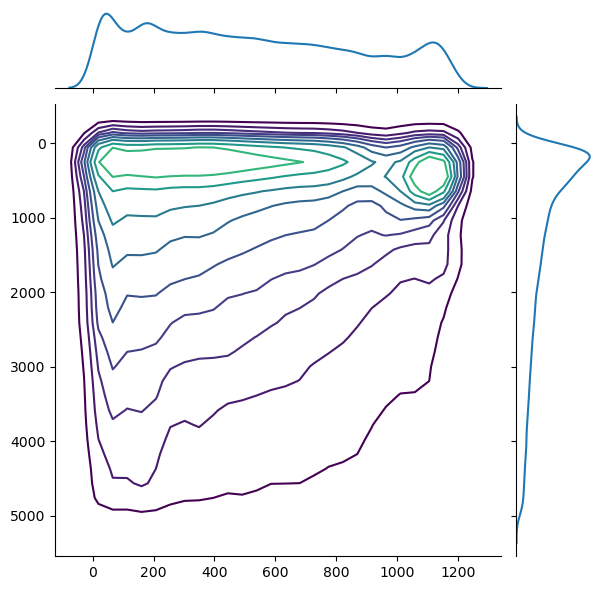

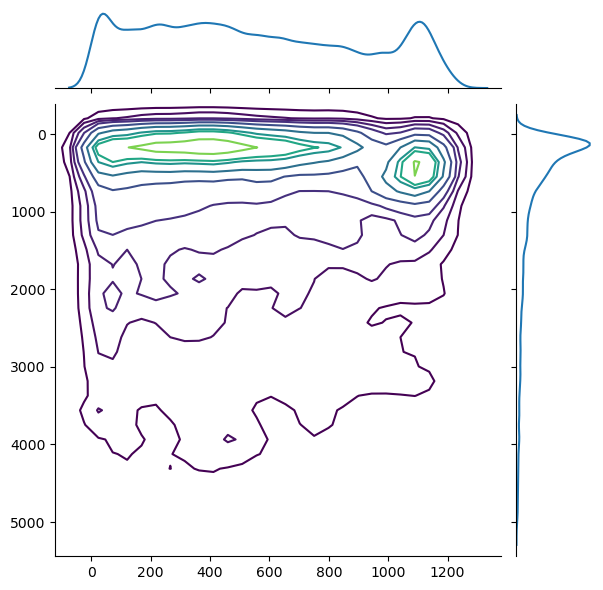

In [13]:
links_in_pages = pd.read_pickle('data/links_in_pages_DF.pkl')

with open('data/x_coordinate_list.pkl', 'rb') as file:
    x_coordinate_list = pickle.load(file)

with open('data/y_coordinate_list.pkl', 'rb') as file_2:
    y_coordinate_list = pickle.load(file_2)

x_list = []
y_list = []

for i in range(len(x_coordinate_list)):
    if x_coordinate_list[i]>0 and y_coordinate_list[i]>0 and y_coordinate_list[i]<5000:
        x_list.append(x_coordinate_list[i])
        y_list.append(y_coordinate_list[i])
'''
with open('data/x_coordinate_list.pkl', "rb") as input_file:
    x_coordinate_list = pickle.load(input_file)

with open('data/y_coordinate_list.pkl', "rb") as input_file:
    y_coordinate_list = pickle.load(input_file)

'''
clicked_links = pd.DataFrame({'X' : x_list,
'Y' : y_list})


filtered_df = links_in_pages.query('Y < 5000 & Y > 0')
filtered_df = filtered_df.query('X < 1200 & X > 0')
plt.figure()
jointplot_2 = sns.jointplot(x=list(filtered_df['X']), y=list(filtered_df['Y']), kind='kde', gridsize = 32, cmap='viridis')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
#cbar_ax = jointplot_2.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
#cbar = plt.colorbar(cax=cbar_ax)
plt.show()

jointplot = sns.jointplot(x  = x_list , y = y_list , kind = 'kde', gridsize = 32, cmap = 'viridis')

ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
#cbar_ax = jointplot.fig.add_axes([.85, .25, .05, .4])

plt.show()






In [12]:
#lets define two vectors of distances from the top left in order to compare both clicked links and links in page
distance_links = np.array(links_in_pages['distance'])
distance_clicked = np.zeros(len(distance_links))

for i in range(1, len(distance_links)):
    distance_clicked[i] = np.sqrt(x_list[i]**2 + y_list[i]**2)

print(np.size(distance_clicked), np.size(distance_links))

180031 180031


In [23]:
#decriptive statistics of distribution of links in pages (y<5000)

links_in_pages[['X', 'Y']].describe()



,X,Y
count,150694.000000,150694.000000
mean,516.158934,1533.641849
std,344.141846,1326.283356
min,19.050003,13.449997
25%,214.350006,405.600006
50%,475.350006,1134.233337
75%,788.549988,2416.158325
max,1199.900024,4999.933105


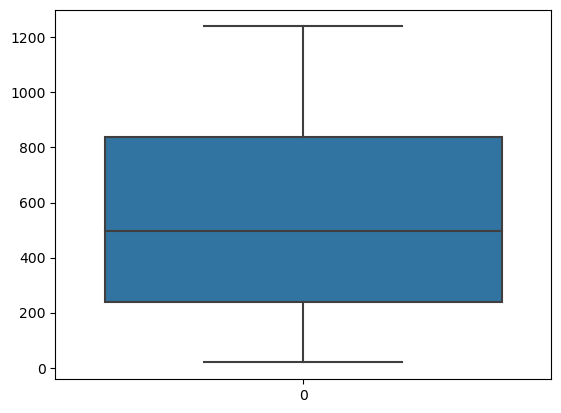

In [19]:
#descriptive stats of clicked links (y<5000)

clicked_links[['X', 'Y']].describe()

boxplot = sns.boxplot(clicked_links['X'])

c:\Users\croge\anaconda3\envs\ada\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


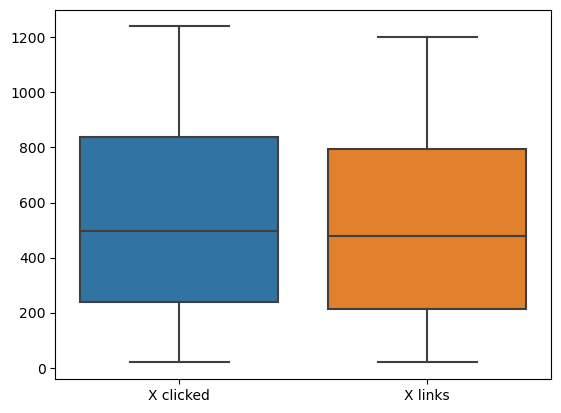

c:\Users\croge\anaconda3\envs\ada\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


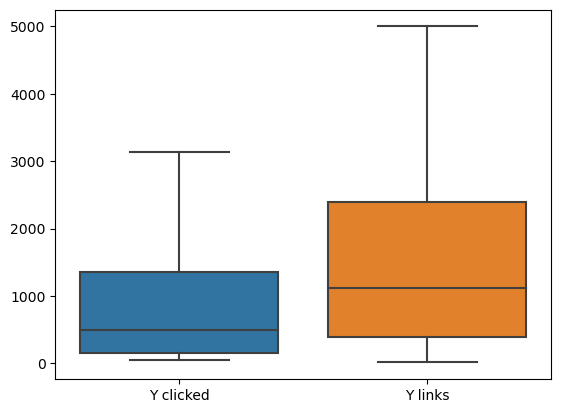

In [27]:
X_coordinates = pd.DataFrame({'X clicked' : clicked_links['X'],
'X links' : filtered_df['X']})

Y_coordinates = pd.DataFrame({'Y clicked' : clicked_links['Y'],
'Y links' : filtered_df['Y']})


sns.boxplot(X_coordinates)

plt.show()

sns.boxplot(Y_coordinates, showfliers = False)

plt.show()

In [15]:
#null hypothesis == mean(links) = mean(clicks)

t_statistic, p_value = ttest_ind(distance_links, distance_clicked )

print(t_statistic, p_value)


171.66182170312757 0.0
